

*   Nama: Farhan
*   Email: farhanarafiq2401@gmail.com
*   Kota: Pontianak




In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('temperature.csv')

In [3]:
df.head

<bound method NDFrame.head of                datetime    Portland
0       10/1/2012 13:00  282.080000
1       10/1/2012 14:00  282.083252
2       10/1/2012 15:00  282.091866
3       10/1/2012 16:00  282.100481
4       10/1/2012 17:00  282.109096
...                 ...         ...
45247  11/29/2017 20:00  282.000000
45248  11/29/2017 21:00  282.890000
45249  11/29/2017 22:00  283.390000
45250  11/29/2017 23:00  283.020000
45251   11/30/2017 0:00  282.280000

[45252 rows x 2 columns]>

In [4]:
# untuk melihat apakah terdapat missing value
# true berarti ada, false berarti tidak ada
df.isnull().values.any()

False

In [5]:
import matplotlib.pyplot as plt

In [6]:
dates = df['datetime'].values
temp = df['Portland'].values

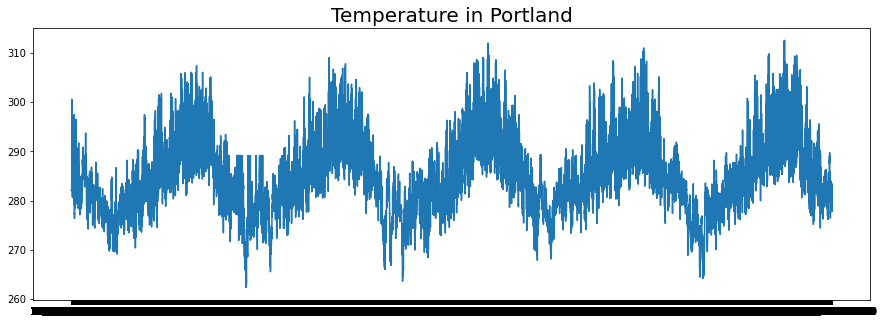

In [7]:
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature in Portland',
          fontsize=20);

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# membagi data training dan data testing
x_train, x_test, y_train, y_test = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [10]:
sd = (df['Portland'].max() - df['Portland'].min()) * 10/100
print(sd)

5.014999999999998


In [11]:
import tensorflow as tf

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
from tensorflow.keras.models import Sequential

In [14]:
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout

In [15]:
# pemodelan sequential dengan menerapkan LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [16]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [18]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [19]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('mae') < 5.0149):
            self.model.stop_training = True 
            print("\nMAE pada model telah < 10% skala data") 
   
callbacks = myCallback()

In [20]:
tf.keras.backend.set_floatx('float64')

In [21]:
history = model.fit(train_set,
                    epochs=200,
                    validation_data = val_set,
                    callbacks=[callbacks])

Epoch 1/200
362/362 [==============================] - 67s 167ms/step - loss: 270.3298 - mae: 270.8298 - val_loss: 108.8608 - val_mae: 109.3608
Epoch 2/200
362/362 [==============================] - 61s 168ms/step - loss: 6.6734 - mae: 7.1504 - val_loss: 6.1466 - val_mae: 6.6329
Epoch 3/200
362/362 [==============================] - 60s 166ms/step - loss: 3.9905 - mae: 4.4643 - val_loss: 5.8798 - val_mae: 6.3621

MAE pada model telah < 10% skala data


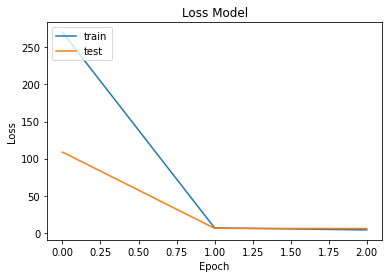

In [22]:
# membuat plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

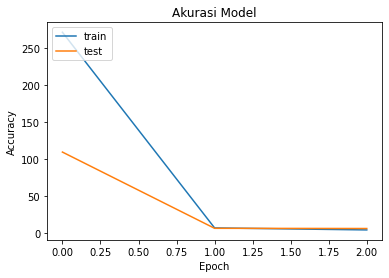

In [23]:
# membuat plot akurasi
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()